In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy import signal
from scipy.stats import skew
%matplotlib  widget 

This notebook masks the disp rate map according to pops 1 & 2 (discarding pixels not in either population), then calculates skew values over a moving window (of a given size, can change this). Then, takes "mask_smooth" code from velocity_maps_2_populations_pixels_differences_paired_down.ipynb notebook and uses it to smooth out the skew map 

In [2]:
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
fileName = 'interval_5_unfilt_weighted_ref_to_ref_pix_HP_phs_jump_cutoff.r4'
f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None

dy = np.shape(disp_rates)[0]
dx = np.shape(disp_rates)[1]
print(dy,dx)

1100 4000


In [3]:
# load in the pop1 mask and pop2 mask 
maskDir = '/home/ocp4/data/LagunaSalada/Data_and_Figs/17_pixel_populations/'
pop1_file = 'pop1_mask_version2.r4'
f1 = gdal.Open(maskDir+pop1_file, gdal.GA_ReadOnly)
pop1_mask = f1.ReadAsArray(); f1 = None
pop2_file = 'pop2_mask_version2.r4'
f1 = gdal.Open(maskDir+pop2_file, gdal.GA_ReadOnly)
pop2_mask = f1.ReadAsArray(); f1 = None
print('Pop 1 and 2 masks loaded.')

Pop 1 and 2 masks loaded.


colormap made where NANs will be green.


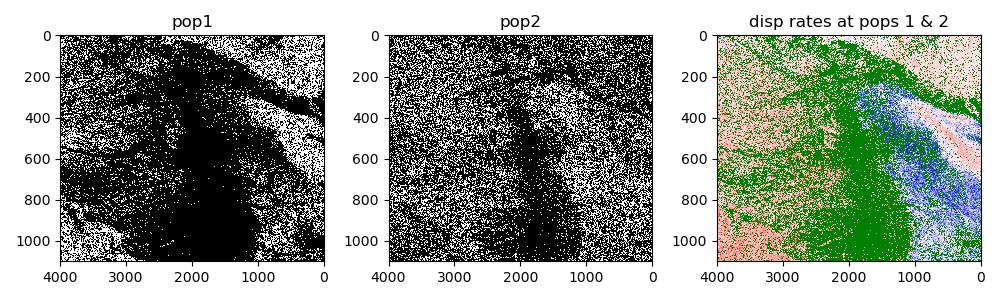

In [4]:
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(pop1_mask,aspect='auto',interpolation='nearest',cmap='gray')
plt.title('pop1')
plt.xlim(dx,0)
plt.subplot(1,3,2)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
plt.imshow(pop2_mask,aspect='auto',interpolation='nearest',cmap='gray')
plt.title('pop2')
plt.xlim(dx,0)

# combine them 
pops_mask = pop1_mask + pop2_mask
# mask the disp rates based on the pops
masked_disp_rates = np.ma.masked_where(pops_mask==0,disp_rates)

seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

plt.subplot(1,3,3)
plt.imshow(masked_disp_rates,aspect='auto',interpolation='nearest',cmap=seismic2)
plt.xlim(dx,0)
plt.title('disp rates at pops 1 & 2')
plt.show()

In [5]:
# mask the disp rates based on the pops
masked_disp_rates = np.ma.masked_where(pops_mask==0,disp_rates)

In [6]:
alooks = 8      # y-direction, start with 4
rlooks = 40     # x-direction, start with 20

skew_vals = np.zeros((dy,dx))
std_devs = np.zeros((dy,dx))
for y in range(dy):       # dy for all pixels 
    for x in range(dx):   # dx for all pixels 
        if y-alooks/2 < 0 or y+alooks/2 >= dy or x-rlooks/2 < 0 or x+rlooks/2 >= dx:
            skew_vals[y,x] = float('nan')
            std_devs[y,x] = float('nan')
            #print('('+str(y)+','+str(x)+') nan')
        else: 
            #skew_vals[y,x] = skew(unwr_full_res[k,y-int(alooks/2):y+int(alooks/2),x-int(rlooks/2):x+int(rlooks/2)])
            skew_vals[y,x] = skew((masked_disp_rates[y-int(alooks/2):y+int(alooks/2),x-int(rlooks/2):x+int(rlooks/2)]).flatten(),nan_policy='omit')
            #std_devs[y,x] = np.nanstd((masked_disp_rates[y-int(alooks/2):y+int(alooks/2),x-int(rlooks/2):x+int(rlooks/2)]).flatten())
            #print('('+str(y)+','+str(x)+') skew')
print('skew + std. dev. values calculated for all pixels of this igram.')

/home/ocp4/miniforge3/envs/earthscope_insar/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1171: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/ocp4/miniforge3/envs/earthscope_insar/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/ocp4/miniforge3/envs/earthscope_insar/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ocp4/miniforge3/envs/earthscope_insar/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


skew + std. dev. values calculated for all pixels of this igram.


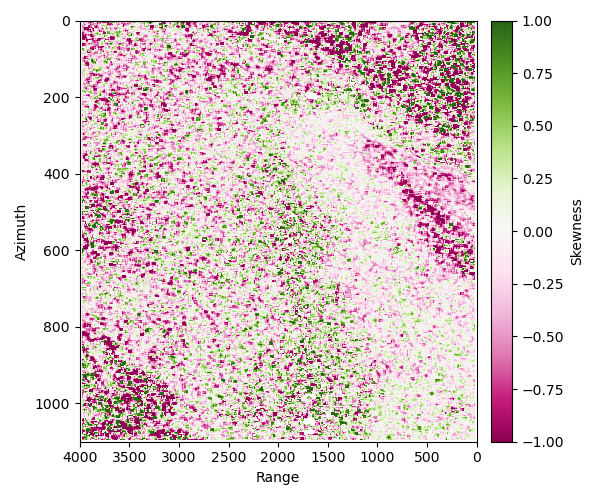

In [7]:
plt.figure(figsize=(6,5),tight_layout=True) 
plt.imshow(skew_vals,aspect='auto',interpolation='nearest',vmin=-1,vmax=1,extent=[0,dx,dy,0]) #,vmin=-0.5,vmax=0.5
plt.colorbar(orientation='vertical',pad=0.03,label='Skewness'); plt.set_cmap('PiYG')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.xlabel('Range'); plt.ylabel('Azimuth')
plt.show()
#plt.savefig("skew_map.png", transparent=True)

In [8]:
# this just spreads out the Nans. So I have to use a different way.
skew_map_filt = gaussian_filter(skew_vals,sigma=[alooks*10,rlooks*10])
skew_vals[skew_vals != skew_vals] = np.nan

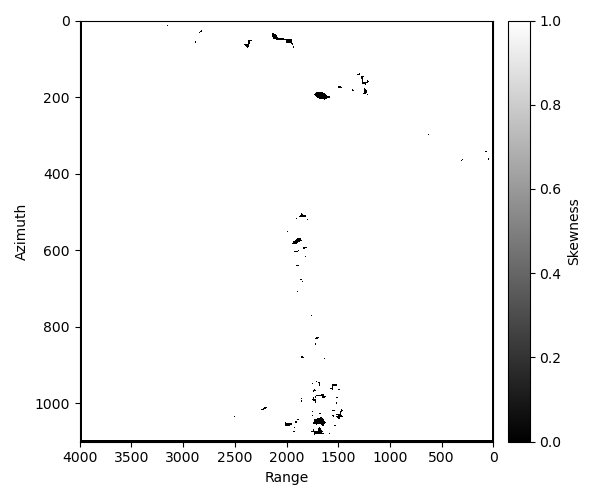

In [9]:
mask = np.zeros((dy,dx))
mask[skew_vals == skew_vals] = 1.0

plt.figure(figsize=(6,5),tight_layout=True) 
plt.imshow(mask,aspect='auto',vmin=0,vmax=1,interpolation='nearest',extent=[0,dx,dy,0]) 
plt.colorbar(orientation='vertical',pad=0.03,label='Skewness'); plt.set_cmap('gray')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.xlabel('Range'); plt.ylabel('Azimuth')
plt.show()

Now smooth this map so I can see actual trends. 

In [10]:
# convolve a gaussian kernel instead of using gaussian_filter 
def mask_smooth(masked_array,disp_rates,dy,dx):
    #mask_y,mask_x = np.nonzero(masked_array)    # find pix where values haven't been masked
    mask = np.zeros((dy,dx))                    # initialize an array of zeros that's the same size as input for the mask
    mask[np.nonzero(masked_array)] = 1.0                   # put 1's in the spots that had real values 
    #alooks = 4                                  # amount to filter in the azimuth/y direction
    alooks = 4*2
    #rlooks = 20                                 # amount to filter in the range/x direction
    rlooks = 20*2 # TRY THIS 
    # create Gaussian kernel with proper size
    stdrg = alooks # range, usually rlooks
    stdaz = rlooks # azimuth, usually alooks 
    kernlenrg = 8*stdrg+1 # can try this as 2 
    kernlenaz = 8*stdaz+1
    kernrg = signal.gaussian(kernlenrg, std=stdrg) #.reshape(kernlenrg,1)
    kernaz = signal.gaussian(kernlenaz, std=stdaz) #.reshape(kernlenaz,1)
    # Notes: 
    # signal.gaussian() takes 2 args: 
    #   first arg: number of points in the output window, this is the entire window size and I 
    #              defined it so that it doesn't drop off to zero too soon. I made it the same 
    #              as what gaussian_filter does. 
    #   second arg: standard deviation, this determines the size of the Gaussian signal/normal
    #               distribution. Same as the half-width of the curve, so 2*std is the width 
    #               of the Gaussian/normal distribution.  
    wind = np.outer(kernrg,kernaz)
    wind = wind/np.sum(wind)
    print('kernel created.')
    mask_filt = signal.convolve2d(mask, wind, mode='same')  # filter the mask to smear it out   
    print('kernel convolved with mask.')
    # Nans_y,Nans_x = np.where(mask_filt==0)      # find where the filtered mask didn't reach (which pix are still 0)
    vels_masked = np.zeros((dy,dx))             # initialize array of zeros that's the same size as input for the velocities
    vels_masked[np.nonzero(masked_array)] = disp_rates[np.nonzero(masked_array)]      # put in the "good" disp rates into the masked vels array.
    vels_filt = signal.convolve2d(vels_masked, wind, mode='same')  # filter the vels_masked 
    print('kernel convolved with masked velocities.')    
    # divide the two
    ab_Nans = vels_filt / mask_filt     # start with an array that will have some Nans in it. 
    ab = np.copy(ab_Nans)               # make a copy of it to put zeros back in for the Nans.
    ab[mask_filt==0] = 0.0             # this is where it gave 0/0=Nan, put zeros back in. 
    print('convolved velocities divided by convolved mask.')
    # calculate the variance of the velocity 
    #residuals_Nans = masked_array-ab                   # removed on avg the mean, this is (value-mean) 
    residuals_Nans = np.zeros((dy,dx))*np.nan           # start with array of Nans
    residuals_Nans[np.nonzero(masked_array)] = disp_rates[np.nonzero(masked_array)]-ab[np.nonzero(masked_array)]     
    # above is residuals of filtered vels for non-masked pixels, minus original vels for non-masked pixels
    residuals2_Nans = np.square(residuals_Nans)                     # (value-mean)^2
    residuals2 = np.zeros((dy,dx))                                  # start with array of zeros
    residuals2[np.nonzero(masked_array)] = residuals2_Nans[np.nonzero(masked_array)]      # picking out values from mask where residuals are meaningful 
    print('residuals and residuals^2 calculated between input vels and smoothed vels.')
    var_filt = signal.convolve2d(residuals2, wind, mode='same')    # avg of the (value-mean)^2
    print('residuals convolved with window to get smoothed variances.')
    var_multiplier = signal.convolve2d(mask,wind**2,mode='same')
    print('multiplier calcualted to get variances of vel means')
    # variance of velocities 
    #mask_num_pix = mask_filt * (alooks*rlooks) - 1  # this gives you number of pixels - 1, weighted by Gaussian filter 
    var_ab = var_filt/mask_filt                 # divide by mask to not create edge effects that drop off to zero 
    var_ab[mask_filt==0] = np.nan              # put Nans where the smoothed values didn't reach.
    print('smoothed variances divided by smoothed mask.')
    # variance of means of velocity         
    var_mean_ab = var_ab*var_multiplier         # get the variance of the means, dividing by the num of pixels 
    var_mean_ab[mask_filt==0] = np.nan         # put Nans back in where no values should be. 
    print('variances of mean vels calculated.')
    return mask_filt, ab_Nans, var_ab, var_mean_ab

In [11]:
mask_filt, skew_map_filt, var_ab, var_mean_ab = mask_smooth(mask,skew_vals,dy,dx)

/tmp/ipykernel_121261/647402713.py:15: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernrg = signal.gaussian(kernlenrg, std=stdrg) #.reshape(kernlenrg,1)
/tmp/ipykernel_121261/647402713.py:16: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernaz = signal.gaussian(kernlenaz, std=stdaz) #.reshape(kernlenaz,1)


kernel created.
kernel convolved with mask.
kernel convolved with masked velocities.
convolved velocities divided by convolved mask.
residuals and residuals^2 calculated between input vels and smoothed vels.
residuals convolved with window to get smoothed variances.
multiplier calcualted to get variances of vel means
smoothed variances divided by smoothed mask.
variances of mean vels calculated.


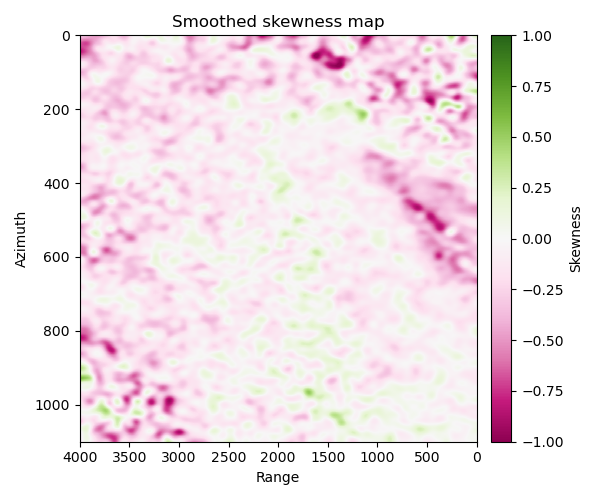

In [12]:
plt.figure(figsize=(6,5),tight_layout=True) 
plt.imshow(skew_map_filt,aspect='auto',interpolation='nearest',vmin=-1,vmax=1,extent=[0,dx,dy,0]) #,vmin=-0.5,vmax=0.5
plt.colorbar(orientation='vertical',pad=0.03,label='Skewness'); plt.set_cmap('PiYG')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title('Smoothed skewness map')
plt.xlabel('Range'); plt.ylabel('Azimuth')
plt.show()

nan


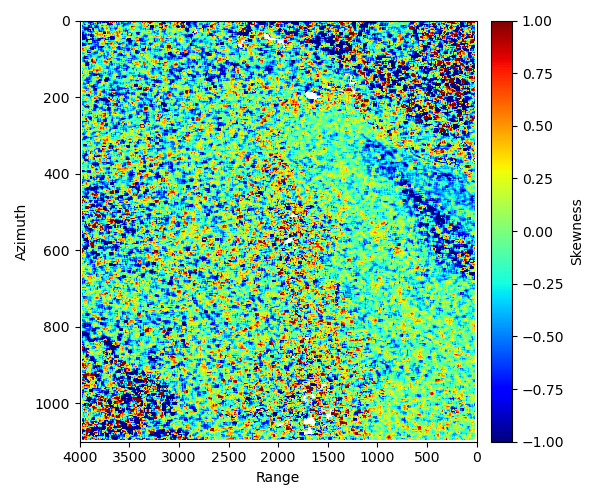

In [13]:
# put zeros in instead of Nans
skew_map_no_Nans = np.zeros((dy,dx))
skew_map_no_Nans[skew_vals != np.nan] = skew_vals[skew_vals != np.nan]

print(skew_vals[511,1843])

plt.figure(figsize=(6,5),tight_layout=True) 
#plt.subplot(1,2,1)
plt.imshow(skew_map_no_Nans,aspect='auto',interpolation='nearest',vmin=-1,vmax=1,extent=[0,dx,dy,0]) #,vmin=-0.5,vmax=0.5
plt.colorbar(orientation='vertical',pad=0.03,label='Skewness'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.xlabel('Range'); plt.ylabel('Azimuth')
#plt.title('disp rate map skew vals',fontsize=15)
# plt.subplot(1,2,2)
# plt.imshow(std_devs,aspect='auto',interpolation='nearest',extent=[0,dx,dy,0])
# plt.colorbar(orientation='vertical',pad=0.03,label='std dev'); plt.set_cmap('jet')
# plt.xlim([dx,0]); plt.ylim([dy,0])
# plt.title('disp rate map std devs',fontsize=15)
plt.show()
#plt.savefig("skew_map.png", transparent=True)


mask = np.zeros((dy,dx))
mask[skew_vals != np.nan] = 1.0
mask_filt = gaussian_filter(mask,sigma=[alooks*2,rlooks*2])
#skew_map_filt_corr = 

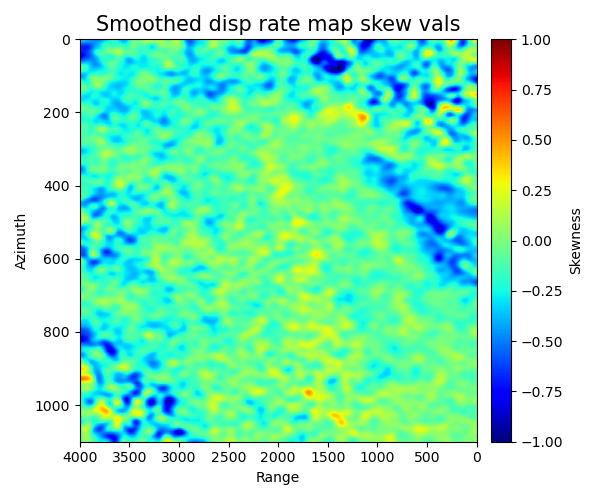

In [14]:
plt.figure(figsize=(6,5),tight_layout=True) 
plt.imshow(skew_map_filt,aspect='auto',interpolation='nearest',vmin=-1,vmax=1,extent=[0,dx,dy,0]) #,vmin=-0.5,vmax=0.5
plt.colorbar(orientation='vertical',pad=0.03,label='Skewness'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.xlabel('Range'); plt.ylabel('Azimuth')
plt.title('Smoothed disp rate map skew vals',fontsize=15)
plt.show()